In [2]:
library(DESeq2)
library(dplyr)
library(glue)
library(ggplot2)
library(ggsignif)
library(car)
setwd('data/inhouse_wu_long_yu')

# Figure 5A: ERV expression and BAP1 mutation status

## Construct expression counts matrix

Sample IDs we are using in the analysis

In [3]:
samples = read.table('scte/KIRC/model/BAP1_status_pLOF_WT_388.tsv', sep = '\t', check.names = FALSE, header = TRUE)
samples = samples$cbioportal_id

Rows: TEs
Columns: Sample IDs

In [5]:
counts = read.table('scte/KIRC/counts/scte_counts_399.txt', sep = '\t', check.names = F, header = TRUE)
row.names(counts) = counts[,1]
counts = counts[,-1]
head(counts)
dim(counts)

,TCGA-3Z-A93Z-01,TCGA-6D-AA2E-01,TCGA-A3-3306-01,TCGA-A3-3307-01,TCGA-A3-3308-01,TCGA-A3-3311-01,TCGA-A3-3313-01,TCGA-A3-3316-01,TCGA-A3-3317-01,TCGA-A3-3319-01,⋯,TCGA-G6-A5PC-01,TCGA-G6-A8L6-01,TCGA-G6-A8L7-01,TCGA-G6-A8L8-01,TCGA-GK-A6C7-01,TCGA-MM-A563-01,TCGA-MM-A564-01,TCGA-MM-A84U-01,TCGA-MW-A4EC-01,TCGA-T7-A92I-01
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
(CATTC)n,8,0,557,342,4,5,101,389,22,27,⋯,250,15,13,10,38,1,22,25,22,2
(GAATG)n,11,25,593,291,32,70,137,549,70,94,⋯,406,48,23,27,89,22,20,62,15,30
A1BG,335,153,57,92,130,137,56,90,227,361,⋯,204,193,364,186,442,236,185,255,309,774
A1BG-AS1,393,218,122,158,192,228,166,229,375,630,⋯,179,226,284,277,592,343,206,286,422,1116
A1CF,1335,527,1926,3414,2254,4625,735,1301,1049,3164,⋯,488,687,11,1209,4691,1036,191,345,1946,25
A2M,4527,4212,4249,4588,4804,4723,4561,4595,4860,4539,⋯,1960,3793,1806,4463,4831,4626,4414,4631,4710,4273


[1] 58389   399

Subset to samples in the analysis and **TEs** only.

In [6]:
te_counts = read.table('scte/preprocessing/unfiltered_combined_scte.txt', sep = '\t', header = TRUE, check.names = FALSE)
tes = colnames(te_counts)[-1]
tes = gsub("\\.", "-", tes)
tes = intersect(row.names(counts), tes)
length(tes)
tes_counts = counts[tes, samples]

[1] 815

## Format metadata for model

In [7]:
# BAP1 pLOF status, purity, stage
bap1_status = read.table('scte/KIRC/model/BAP1_status_pLOF_WT_388.tsv', sep = '\t', check.names = FALSE, header = TRUE)
purity = read.table('scte/KIRC/model/purity_BAP1_pLOF_WT_388.tsv', sep = '\t', check.names = FALSE, header = TRUE)
clinical = read.table('scte/KIRC/model/clinical_BAP1_pLOF_WT_388.tsv', sep = '\t', check.names = FALSE, header = TRUE)

In [8]:
metadata = dplyr::inner_join(bap1_status, purity, by = 'cbioportal_id')
metadata = dplyr::inner_join(metadata, clinical, by = 'cbioportal_id')
row.names(metadata) = metadata$cbioportal_id
metadata$cbioportal_id = NULL
metadata$pLOF = factor(metadata$pLOF)
head(metadata)

,pLOF,CPE,PATIENT_ID,SUBTYPE,CANCER_TYPE_ACRONYM,OTHER_PATIENT_ID,AGE,SEX,AJCC_PATHOLOGIC_TUMOR_STAGE,AJCC_STAGING_EDITION,⋯,IN_PANCANPATHWAYS_FREEZE,OS_STATUS,OS_MONTHS,DSS_STATUS,DSS_MONTHS,DFS_STATUS,DFS_MONTHS,PFS_STATUS,PFS_MONTHS,GENETIC_ANCESTRY_LABEL
,<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>
TCGA-BP-4985-01,1,0.5801,TCGA-BP-4985,KIRC,KIRC,c285ada3-fd49-46a5-882f-b6c352572e2a,72,Male,STAGE III,,⋯,Yes,1:DECEASED,31.298287,1:DEAD WITH TUMOR,31.298287,,NA,1:PROGRESSION,6.739652,EUR
TCGA-B8-A54G-01,1,0.5778,TCGA-B8-A54G,KIRC,KIRC,EA456A1F-6E2C-4B34-AD24-CCD614BD57C9,50,Male,STAGE I,7TH,⋯,Yes,0:LIVING,1.742447,0:ALIVE OR DEAD TUMOR FREE,1.742447,0:DiseaseFree,1.742447,0:CENSORED,1.742447,AFR
TCGA-BP-4962-01,1,0.5991,TCGA-BP-4962,KIRC,KIRC,b3a9b0be-2ccb-4e55-b72c-3f218ca46a3e,58,Male,STAGE II,,⋯,Yes,0:LIVING,58.684288,0:ALIVE OR DEAD TUMOR FREE,58.684288,,NA,0:CENSORED,58.684288,EUR
TCGA-A3-3317-01,1,0.5517,TCGA-A3-3317,KIRC,KIRC,8ee720b5-6f3a-4921-85ab-70e75c0835b0,67,Male,STAGE II,,⋯,Yes,0:LIVING,49.018641,0:ALIVE OR DEAD TUMOR FREE,49.018641,,NA,1:PROGRESSION,18.410757,EUR
TCGA-BP-5182-01,1,0.5143,TCGA-BP-5182,KIRC,KIRC,315b6dea-02c6-44dc-9788-a72f78fae815,56,Male,STAGE I,,⋯,Yes,0:LIVING,38.300950,0:ALIVE OR DEAD TUMOR FREE,38.300950,,NA,0:CENSORED,38.300950,EUR
TCGA-CJ-4636-01,1,0.7129,TCGA-CJ-4636,KIRC,KIRC,2d8da564-e69f-4bfa-a1d3-227a294f3886,51,Male,STAGE III,,⋯,Yes,0:LIVING,63.254101,0:ALIVE OR DEAD TUMOR FREE,63.254101,,NA,0:CENSORED,63.254101,EUR


## Normalize expression data with DESeq

In [10]:
dds <- DESeqDataSetFromMatrix(countData = tes_counts, colData = metadata, design = ~ AJCC_PATHOLOGIC_TUMOR_STAGE + CPE + pLOF)
dds <- DESeq(dds)

## Extract normalized data
vsd <- varianceStabilizingTransformation(dds, blind=TRUE)  # 'blind=FALSE' means that the transformation will take the design into account
vsd_counts <- assay(vsd)

# Create DF with normalized data
normalized = data.frame(check.names = FALSE,
    'ERV3-16A3_LTR' = vsd_counts['ERV3-16A3_LTR',])
normalized$ids = row.names(normalized)
head(normalized)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
 

,ERV3-16A3_LTR,ids
,<dbl>,<chr>
TCGA-BP-4985-01,9.437371,TCGA-BP-4985-01
TCGA-B8-A54G-01,9.886411,TCGA-B8-A54G-01
TCGA-BP-4962-01,9.735261,TCGA-BP-4962-01
TCGA-A3-3317-01,9.670348,TCGA-A3-3317-01
TCGA-BP-5182-01,9.738445,TCGA-BP-5182-01
TCGA-CJ-4636-01,9.507890,TCGA-CJ-4636-01


Combine normalized counts with metadata

In [11]:
# create DF to use in model by combining counts with metadata
metadata$ids = row.names(metadata)
model_df = dplyr::inner_join(metadata, normalized, by = 'ids')

## Evaluate relationship between ERV expression and BAP1 mutation status and plot

In [12]:
model_df$pLOF = factor(model_df$pLOF, levels = c(0,1))
fit = lm(model_df[, 'ERV3-16A3_LTR'] ~ pLOF + scale(CPE) + scale(AGE) + SEX + AJCC_PATHOLOGIC_TUMOR_STAGE + HISTORY_NEOADJUVANT_TRTYN, data = model_df)
summary(fit)


Call:
lm(formula = model_df[, "ERV3-16A3_LTR"] ~ pLOF + scale(CPE) + 
    scale(AGE) + SEX + AJCC_PATHOLOGIC_TUMOR_STAGE + HISTORY_NEOADJUVANT_TRTYN, 
    data = model_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.78135 -0.09519  0.01067  0.10079  0.45825 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           9.573527   0.015683 610.426   <2e-16 ***
pLOF1                                 0.082681   0.032883   2.514   0.0123 *  
scale(CPE)                            0.012962   0.008489   1.527   0.1276    
scale(AGE)                           -0.009027   0.008350  -1.081   0.2803    
SEXMale                              -0.019728   0.017456  -1.130   0.2591    
AJCC_PATHOLOGIC_TUMOR_STAGESTAGE II  -0.025347   0.028192  -0.899   0.3692    
AJCC_PATHOLOGIC_TUMOR_STAGESTAGE III -0.032624   0.021407  -1.524   0.1283    
AJCC_PATHOLOGIC_TUMOR_STAGESTAGE IV  -0.051567   0.024149  -2.135   0.0334 *

In [13]:
panels <- list(
  list(width = 0.01),
  list(width = 0.18, display = ~variable, fontface = "bold", heading = "Variable"),
  list(width = 0.1, display = ~level),
  list(width = 0.05, display = ~n, hjust = 1, heading = "N"),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(
    width = 0.15, item = "forest", hjust = 0.5, heading = "Estimate", linetype = "dashed",
    line_x = 0
  ),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(width = 0.12, display = ~ ifelse(reference, "Reference", sprintf(
    "%0.2f (%0.2f, %0.2f)",
    trans(estimate), trans(conf.low), trans(conf.high)
  )), display_na = NA),
  list(
    width = 0.075,
    display = ~ ifelse(reference, "", format.pval(p.value, digits = 1,nsmall = 3, eps = 0.001)),
    display_na = NA, hjust = 1, heading = "p"
  ),
  list(width = 0.01)
)

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


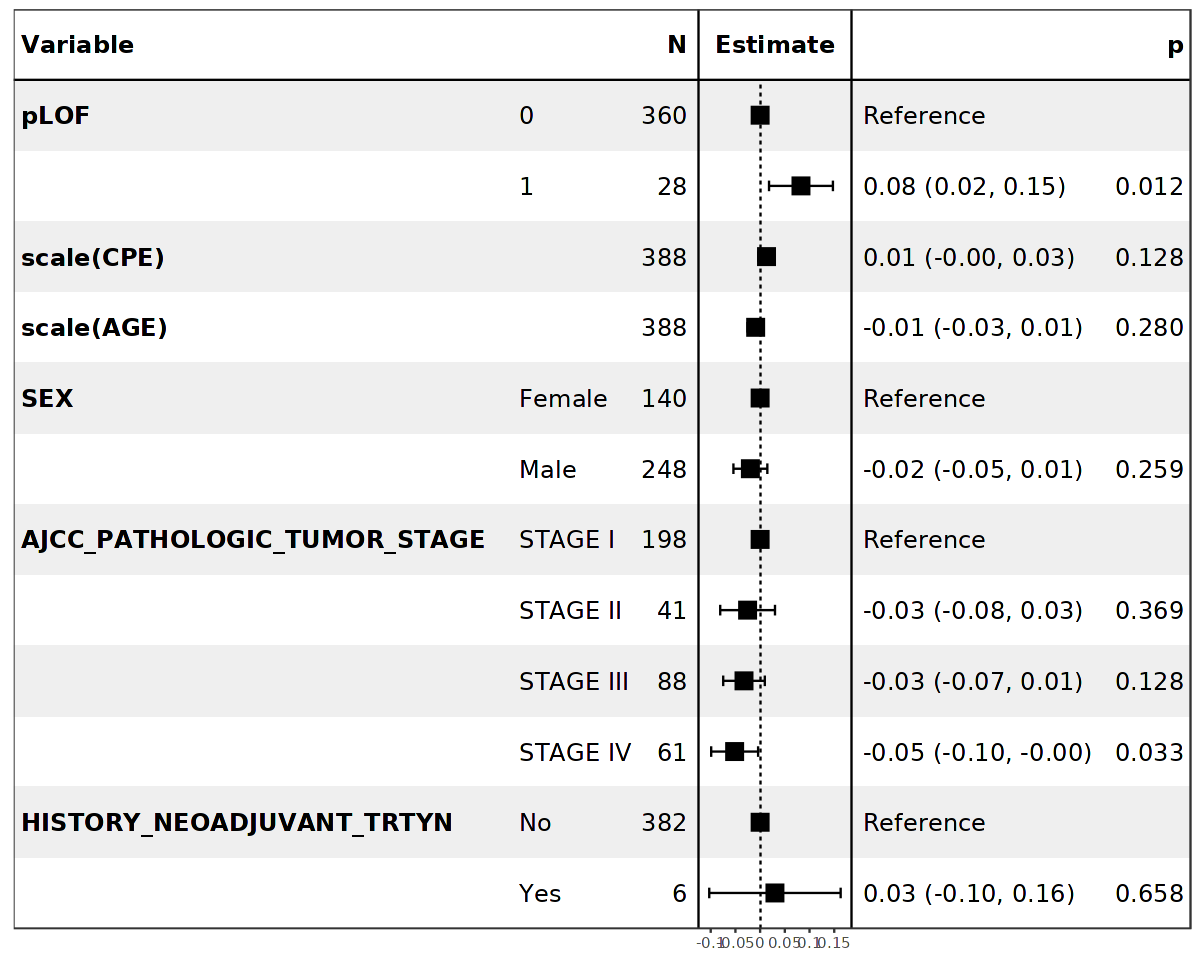

In [15]:
library(forestmodel)
options(repr.plot.width = 10, repr.plot.height = 8)
bap1_erv_exp_plot = forest_model(fit, exponentiate = FALSE, panels = panels)
bap1_erv_exp_plot

# Figure S5A: ERV expression and BAP1 mutation status (Early stage patients only)

Subset to samples from early stage patients and fit lm. 

In [25]:
early_model_df = model_df %>% filter(AJCC_PATHOLOGIC_TUMOR_STAGE %in% c('STAGE I', 'STAGE II'))
fit = lm(early_model_df[, 'ERV3-16A3_LTR'] ~ pLOF + scale(CPE) + scale(AGE) + SEX + AJCC_PATHOLOGIC_TUMOR_STAGE  + HISTORY_NEOADJUVANT_TRTYN, data = early_model_df)
summary(fit)


Call:
lm(formula = early_model_df[, "ERV3-16A3_LTR"] ~ pLOF + scale(CPE) + 
    scale(AGE) + SEX + AJCC_PATHOLOGIC_TUMOR_STAGE + HISTORY_NEOADJUVANT_TRTYN, 
    data = early_model_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.79058 -0.09200  0.00618  0.08990  0.32199 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          9.573868   0.016211 590.594  < 2e-16 ***
pLOF1                                0.179227   0.050310   3.562 0.000446 ***
scale(CPE)                           0.007186   0.009946   0.722 0.470737    
scale(AGE)                          -0.018640   0.009780  -1.906 0.057879 .  
SEXMale                             -0.019897   0.020360  -0.977 0.329446    
AJCC_PATHOLOGIC_TUMOR_STAGESTAGE II -0.035480   0.026688  -1.329 0.185000    
HISTORY_NEOADJUVANT_TRTYNYes         0.036520   0.088592   0.412 0.680558    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Resi

Plot

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


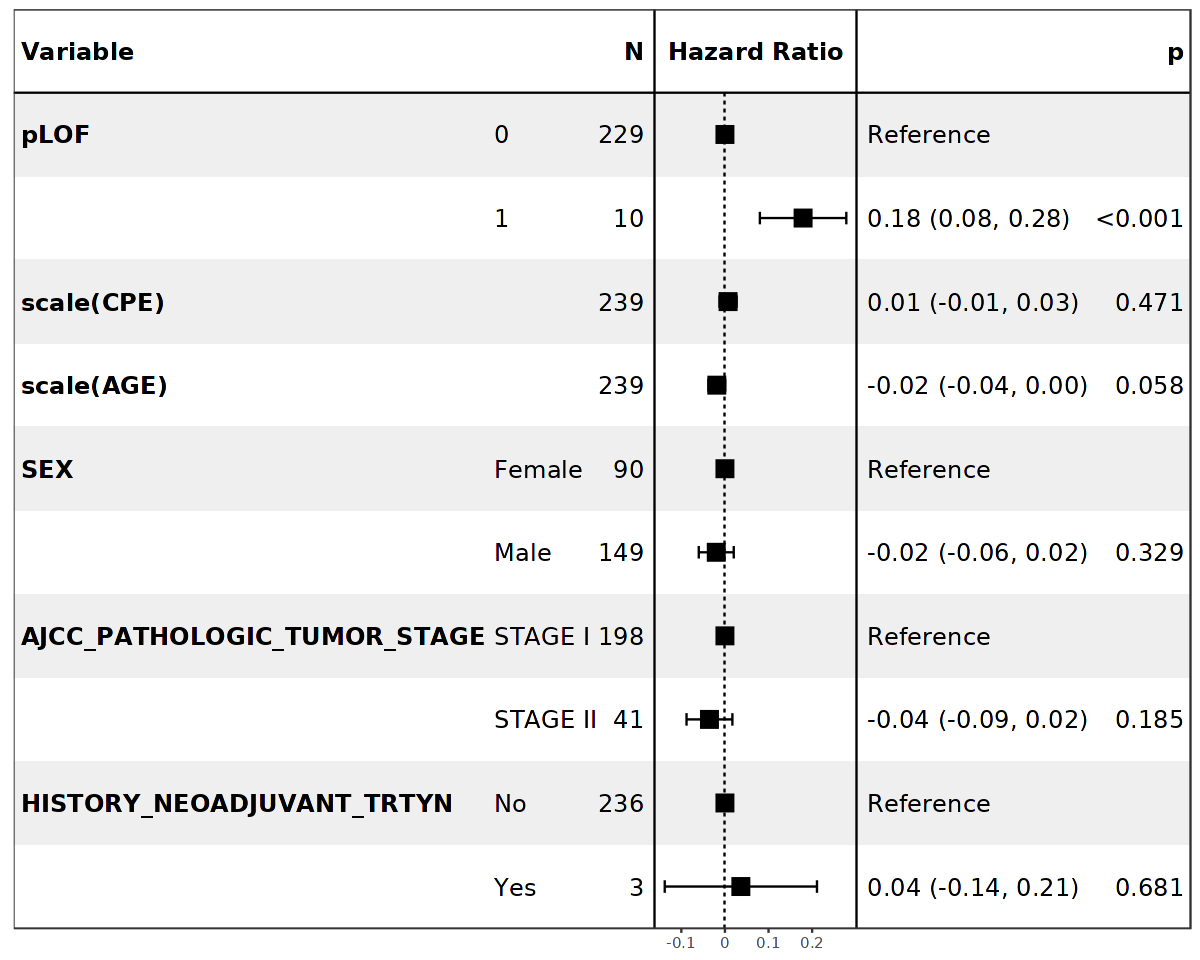

In [26]:
library(forestmodel)
options(repr.plot.width = 10, repr.plot.height = 8)
bap1_erv_exp_plot = forest_model(fit, exponentiate = FALSE, panels = panels)
bap1_erv_exp_plot

# Figure S5B: ERV expression and BAP1 mutation status (Late stage patients only)

Subset to samples from late stage patients and fit lm. 

In [29]:
late_model_df = model_df %>% filter(AJCC_PATHOLOGIC_TUMOR_STAGE %in% c('STAGE III', 'STAGE IV'))
fit = lm(late_model_df[, 'ERV3-16A3_LTR'] ~ pLOF + scale(CPE)+ scale(AGE) + SEX + AJCC_PATHOLOGIC_TUMOR_STAGE  + HISTORY_NEOADJUVANT_TRTYN, data = late_model_df)
summary(fit)


Call:
lm(formula = late_model_df[, "ERV3-16A3_LTR"] ~ pLOF + scale(CPE) + 
    scale(AGE) + SEX + AJCC_PATHOLOGIC_TUMOR_STAGE + HISTORY_NEOADJUVANT_TRTYN, 
    data = late_model_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.62744 -0.09561  0.01775  0.11130  0.46018 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          9.54766    0.03080 309.961   <2e-16 ***
pLOF1                                0.02807    0.04684   0.599    0.550    
scale(CPE)                           0.02254    0.01477   1.526    0.129    
scale(AGE)                           0.00314    0.01521   0.206    0.837    
SEXMale                             -0.02775    0.03272  -0.848    0.398    
AJCC_PATHOLOGIC_TUMOR_STAGESTAGE IV -0.01702    0.03016  -0.564    0.573    
HISTORY_NEOADJUVANT_TRTYNYes         0.03908    0.10609   0.368    0.713    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual stand

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


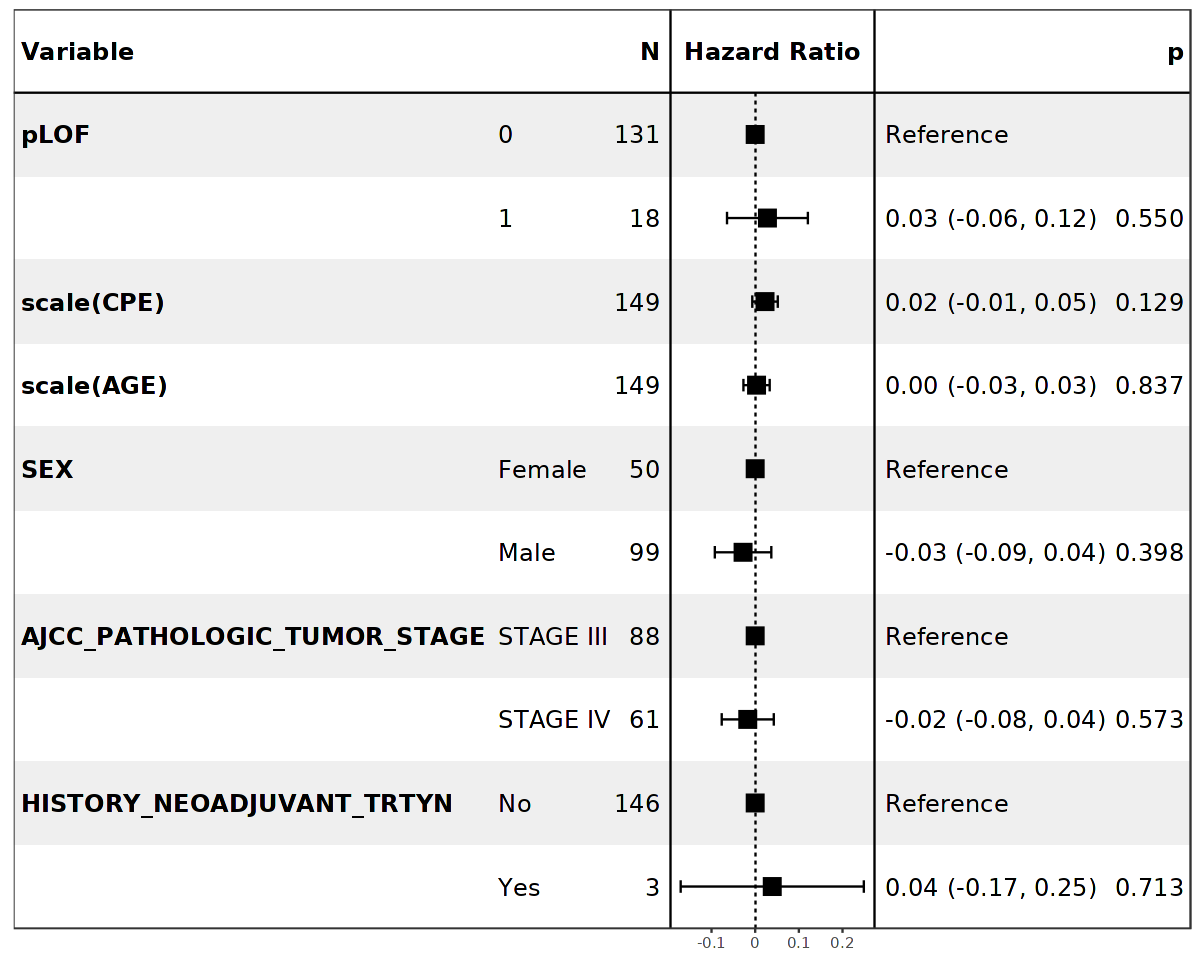

In [30]:
library(forestmodel)
options(repr.plot.width = 10, repr.plot.height = 8)
bap1_erv_exp_plot = forest_model(fit, exponentiate = FALSE, panels = panels)
bap1_erv_exp_plot

# Figure 5B: ERV3_16A3_LTR and OS

In [17]:
library(survival)
library(survminer)

Format, scale, and fit CoxPH model

In [20]:
survival_model_df = model_df %>% 
            mutate(OS_STATUS = dplyr::recode(OS_STATUS, 
                          "0:LIVING" = 0, 
                          "1:DECEASED" = 1),
                  PFS_STATUS = dplyr::recode(PFS_STATUS, 
                          "0:CENSORED" = 0, 
                          "1:PROGRESSION" = 1))

In [21]:
survival_model_df$ERV3_16A3_LTR = scale(survival_model_df[,'ERV3-16A3_LTR'])
survival_model_df$Purity = scale(survival_model_df$CPE)
survival_model_df$Age = scale(survival_model_df$AGE)
survival_model_df$Stage = survival_model_df$AJCC_PATHOLOGIC_TUMOR_STAGE

# Fit Cox PH model
cox_model <- coxph(Surv(OS_MONTHS, OS_STATUS) ~ ERV3_16A3_LTR + pLOF + Purity + Age + SEX + Stage + HISTORY_NEOADJUVANT_TRTYN, data = survival_model_df)
summary(cox_model)

Call:
coxph(formula = Surv(OS_MONTHS, OS_STATUS) ~ ERV3_16A3_LTR + 
    pLOF + Purity + Age + SEX + Stage + HISTORY_NEOADJUVANT_TRTYN, 
    data = survival_model_df)

  n= 388, number of events= 114 

                                 coef exp(coef) se(coef)      z Pr(>|z|)    
ERV3_16A3_LTR                 0.19432   1.21448  0.09683  2.007 0.044764 *  
pLOF1                         0.14681   1.15813  0.32870  0.447 0.655133    
Purity                       -0.13958   0.86972  0.09362 -1.491 0.135976    
Age                           0.63056   1.87866  0.11557  5.456 4.87e-08 ***
SEXMale                       0.22060   1.24683  0.21651  1.019 0.308247    
StageSTAGE II                -0.03162   0.96888  0.45956 -0.069 0.945148    
StageSTAGE III                0.90514   2.47229  0.26654  3.396 0.000684 ***
StageSTAGE IV                 2.31931  10.16867  0.25518  9.089  < 2e-16 ***
HISTORY_NEOADJUVANT_TRTYNYes -0.11152   0.89448  0.55602 -0.201 0.841042    
---
Signif. codes:  0 ‘***’ 0

Plot forest plot of results

In [22]:
panels <- list(
  list(width = 0.01),
  list(width = 0.18, display = ~variable, fontface = "bold", heading = "Variable"),
  list(width = 0.1, display = ~level),
  list(width = 0.05, display = ~n, hjust = 1, heading = "N"),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(
    width = 0.15, item = "forest", hjust = 0.5, heading = "Hazard Ratio", linetype = "dashed",
    line_x = 0
  ),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(width = 0.12, display = ~ ifelse(reference, "Reference", sprintf(
    "%0.2f (%0.2f, %0.2f)",
    trans(estimate), trans(conf.low), trans(conf.high)
  )), display_na = NA),
  list(
    width = 0.075,
    display = ~ ifelse(reference, "", format.pval(p.value, digits = 1,nsmall = 3, eps = 0.001)),
    display_na = NA, hjust = 1, heading = "p"
  ),
  list(width = 0.01)
)

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


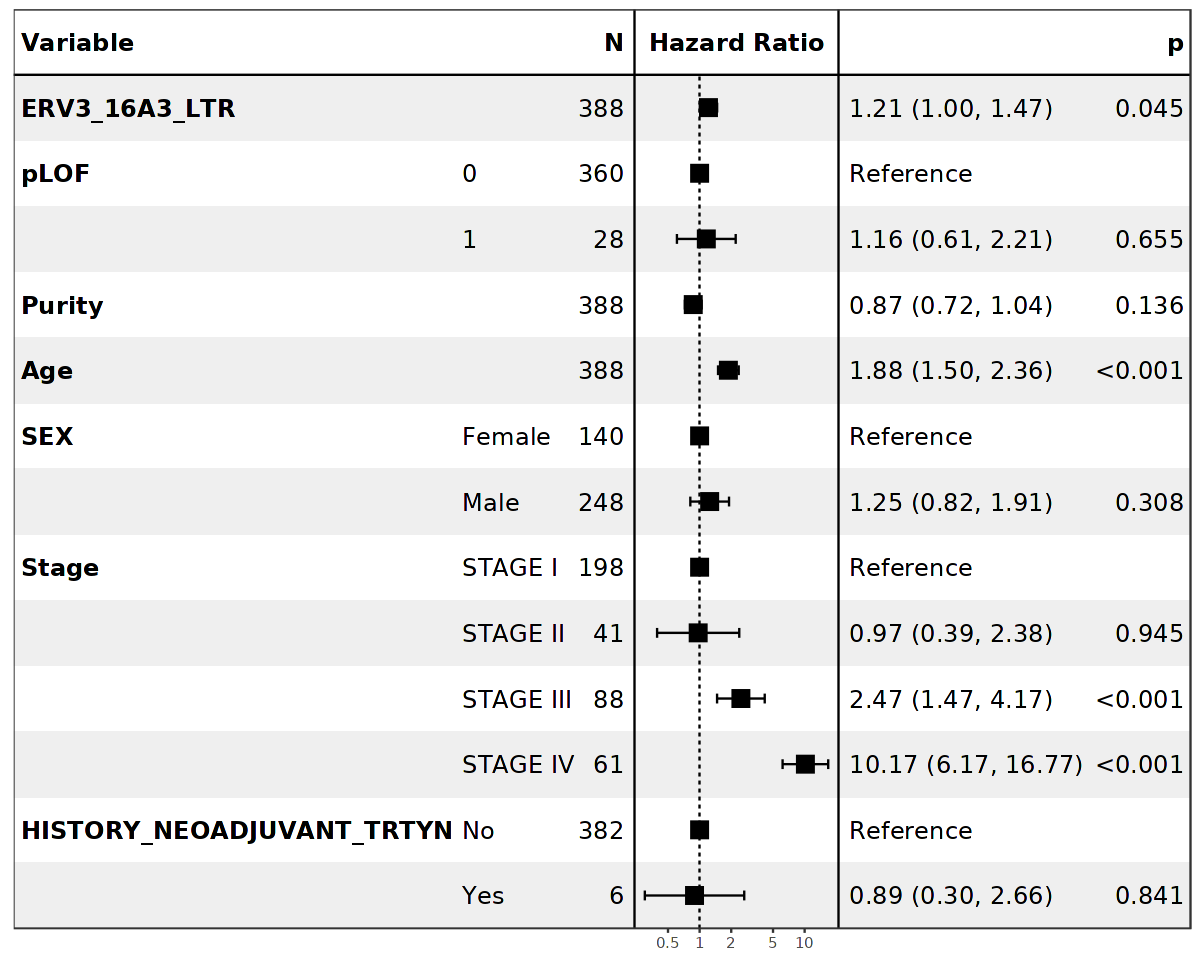

In [23]:
options(repr.plot.width = 10, repr.plot.height = 8)
bap1_erv_surv_plot = forest_model(cox_model, panels = panels)
bap1_erv_surv_plot

# Figure S5C: ERV3_16A3_LTR and OS (Early stage patients only)

In [31]:
early_survival_model_df = survival_model_df %>% filter(Stage %in% c('STAGE I', 'STAGE II'))

# Fit Cox PH model
cox_model <- coxph(Surv(OS_MONTHS, OS_STATUS) ~ ERV3_16A3_LTR  + pLOF + Purity + Age + SEX + Stage + HISTORY_NEOADJUVANT_TRTYN, data = early_survival_model_df)
summary(cox_model)

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  2 ; coefficient may be infinite. ”


Call:
coxph(formula = Surv(OS_MONTHS, OS_STATUS) ~ ERV3_16A3_LTR + 
    pLOF + Purity + Age + SEX + Stage + HISTORY_NEOADJUVANT_TRTYN, 
    data = early_survival_model_df)

  n= 239, number of events= 33 

                                   coef  exp(coef)   se(coef)      z Pr(>|z|)
ERV3_16A3_LTR                 6.224e-01  1.863e+00  2.625e-01  2.371   0.0178
pLOF1                        -1.839e+01  1.026e-08  5.141e+03 -0.004   0.9971
Purity                       -1.875e-01  8.290e-01  2.056e-01 -0.912   0.3616
Age                           9.302e-01  2.535e+00  1.875e-01  4.962 6.98e-07
SEXMale                       3.140e-01  1.369e+00  3.818e-01  0.822   0.4108
StageSTAGE II                 2.428e-01  1.275e+00  4.682e-01  0.519   0.6040
HISTORY_NEOADJUVANT_TRTYNYes  2.529e+00  1.254e+01  1.072e+00  2.358   0.0184
                                
ERV3_16A3_LTR                *  
pLOF1                           
Purity                          
Age                          ***
SEXMa

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


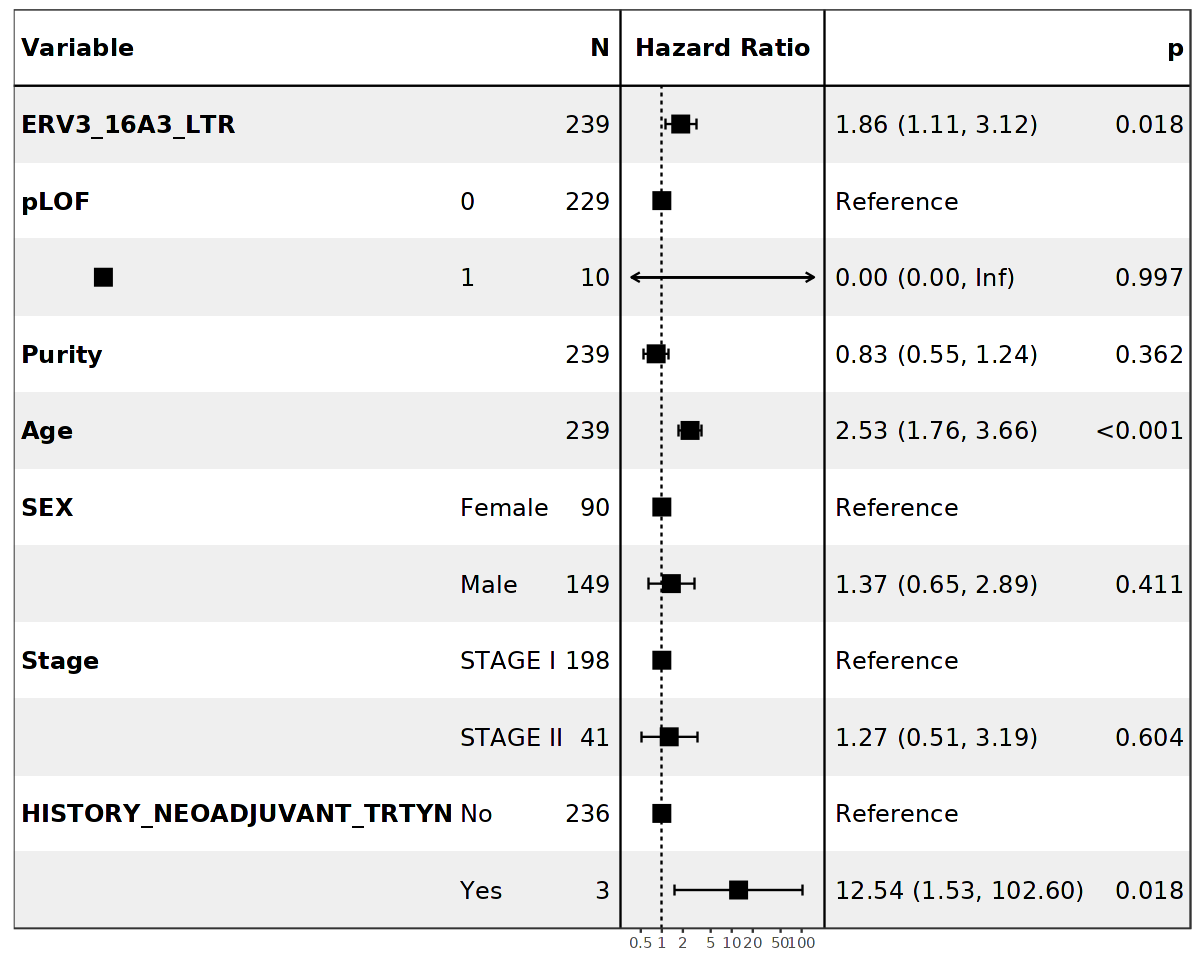

In [32]:
options(repr.plot.width = 10, repr.plot.height = 8)
bap1_erv_surv_plot = forest_model(cox_model, panels = panels, limits = c(-1,log(150)))
bap1_erv_surv_plot

# Figure S5D: ERV3_16A3_LTR and OS (Late stage patients only)

In [33]:
late_survival_model_df = survival_model_df %>% filter(Stage %in% c('STAGE III', 'STAGE IV'))

# Fit Cox PH model
cox_model <- coxph(Surv(OS_MONTHS, OS_STATUS) ~ ERV3_16A3_LTR  + pLOF + Purity + Age + SEX + Stage + HISTORY_NEOADJUVANT_TRTYN, data = late_survival_model_df)
summary(cox_model)

Call:
coxph(formula = Surv(OS_MONTHS, OS_STATUS) ~ ERV3_16A3_LTR + 
    pLOF + Purity + Age + SEX + Stage + HISTORY_NEOADJUVANT_TRTYN, 
    data = late_survival_model_df)

  n= 149, number of events= 81 

                                coef exp(coef) se(coef)      z Pr(>|z|)    
ERV3_16A3_LTR                 0.1434    1.1542   0.1075  1.333  0.18250    
pLOF1                         0.3019    1.3524   0.3532  0.855  0.39266    
Purity                       -0.1390    0.8702   0.1039 -1.338  0.18087    
Age                           0.4575    1.5801   0.1528  2.995  0.00274 ** 
SEXMale                       0.1559    1.1688   0.2698  0.578  0.56332    
StageSTAGE IV                 1.3549    3.8762   0.2375  5.706 1.16e-08 ***
HISTORY_NEOADJUVANT_TRTYNYes -0.3429    0.7097   0.6303 -0.544  0.58648    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                             exp(coef) exp(-coef) lower .95 upper .95
ERV3_16A3_LTR                   1.1542     0.8664

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


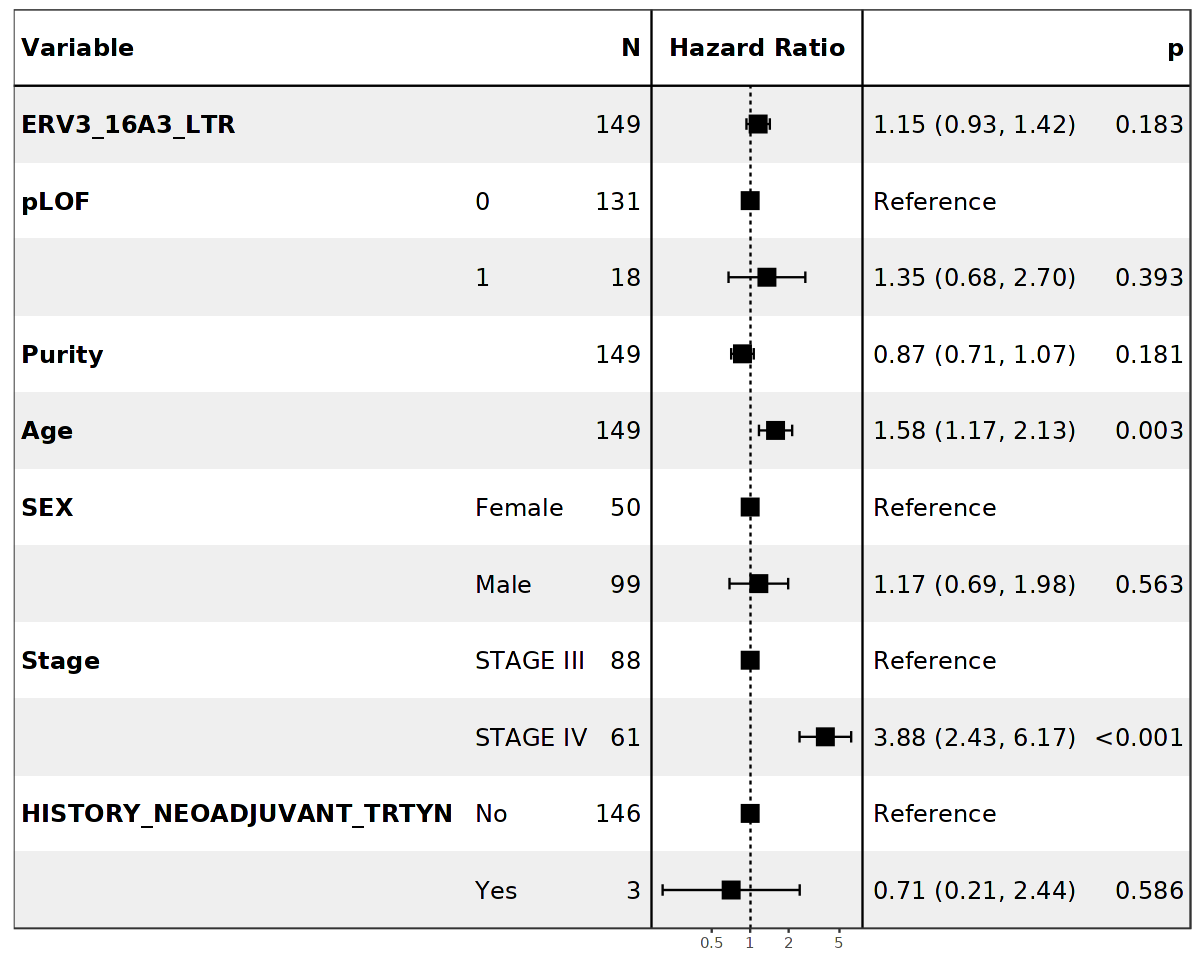

In [34]:
options(repr.plot.width = 10, repr.plot.height = 8)
bap1_erv_surv_plot = forest_model(cox_model, panels = panels)
bap1_erv_surv_plot